# Setup

In [ ]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from einops import rearrange

In [ ]:
!pip install torchvision

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

## Testing (Evaluation)

In [ ]:
def get_eval_data(scale=4, patch_size=64):
  filepath = "/content/drive/MyDrive/CAKRes/DatasetRe16k/test/nskt_Re16000.h5"
  file = h5py.File(filepath, 'r')
  dataset = file['fields']
  n_skip = 2
  n_size = int(2048/n_skip)
  t_size = 100

  display(dataset.shape)

  u = dataset[::, 0, ::n_skip, ::n_skip]
  v = dataset[::, 1, ::n_skip, ::n_skip]
  w = dataset[::, 2, ::n_skip, ::n_skip]

  reshaped_u = u.reshape(t_size, n_size * n_size).T
  reshaped_v = v.reshape(t_size, n_size * n_size).T
  reshaped_w = w.reshape(t_size, n_size * n_size).T

  # Mean and Fluctuations
  mean_u = np.mean(reshaped_u, axis=1).reshape(-1, 1)
  mean_v = np.mean(reshaped_v, axis=1).reshape(-1, 1)
  mean_w = np.mean(reshaped_w, axis=1).reshape(-1, 1)

  eval_dataset = FluidFlowDataset(u, v, w, scale=scale, patch_size=patch_size)

  return eval_dataset

eval_dataset = get_eval_data()

In [ ]:
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False)


## Training

**Here we just use 1000 sample to test the baseline model (due to limited resources as well)**

In [ ]:
filepath = "/content/drive/MyDrive/CAKRes/DatasetRe16k/train/nskt_Re16000.h5"

# Open the H5 file
file = h5py.File(filepath, 'r')

#inspect file structure
def print_structure(name, obj):
    if isinstance(obj, h5py.Group):
        print(f"Group: {name}")
    elif isinstance(obj, h5py.Dataset):
        print(f"Dataset: {name}, Shape: {obj.shape}, Type: {obj.dtype}")

file.visititems(print_structure)

Dataset: fields, Shape: (1000, 3, 2048, 2048), Type: float64


In [ ]:
dataset = file['fields']

t_skip = 5 #reduce time by this factor
n_skip = 2 #reduce u, v, and w grid by this factor
t_size = int(1000/t_skip)
n_size = int(2048/n_skip)


#load the dataset into a numpy array
u = dataset[::t_skip, 0, ::n_skip, ::n_skip]
v = dataset[::t_skip, 1, ::n_skip, ::n_skip]
w = dataset[::t_skip, 2, ::n_skip, ::n_skip]

In [ ]:
# Reshape the u,v,w data: (time, grid, grid) -> (grid x  grid, time)
reshaped_u = u.reshape(t_size, n_size * n_size).T
reshaped_v = v.reshape(t_size, n_size * n_size).T
reshaped_w = w.reshape(t_size, n_size * n_size).T

# Mean and Fluctuations
mean_u = np.mean(reshaped_u, axis=1).reshape(-1, 1)
mean_v = np.mean(reshaped_v, axis=1).reshape(-1, 1)
mean_w = np.mean(reshaped_w, axis=1).reshape(-1, 1)

In [ ]:
display(u.shape)

(200, 1024, 1024)

In [ ]:
!pip install basicsr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_

In [ ]:
from basicsr.archs.swinir_arch import SwinIR
from basicsr.data.transforms import paired_random_crop
from basicsr.utils.img_util import img2tensor, tensor2img

In [ ]:
class FluidFlowDataset(Dataset):
    def __init__(self, u, v, w, scale=4, patch_size=64):
        self.u = u
        self.v = v
        self.w = w
        self.scale = scale
        self.patch_size = patch_size
        self.num_samples = u.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Get HR image (combine all three channels)
        hr = np.stack([self.u[idx], self.v[idx], self.w[idx]], axis=-1)

        # Create LR by downsampling
        lr = hr[::self.scale, ::self.scale, :]

        # Random crop
        hr, lr = paired_random_crop(hr, lr, self.patch_size, self.scale)

        # Convert to tensor
        hr = img2tensor(hr, bgr2rgb=False, float32=True)
        lr = img2tensor(lr, bgr2rgb=False, float32=True)

        return {'lq': lr, 'gt': hr}

# Loss function

In [ ]:
import math

In [ ]:
def _calculate_derivatives(tensor, kernel, padding_val, boundary_mode, spacing):
    """Helper function to calculate derivatives using convolution."""
    if boundary_mode != 'zeros':
        pad = (padding_val, padding_val, padding_val, padding_val)
        tensor_padded = F.pad(tensor, pad, mode=boundary_mode)
        conv_padding = 0
    else:
        tensor_padded = tensor
        conv_padding = padding_val

    derivative = F.conv2d(tensor_padded, kernel, padding=conv_padding) / spacing
    return derivative


In [ ]:
def divergence_loss(predicted_output, dx=2.0*math.pi/2048.0, dy=2.0*math.pi/2048.0, loss_type='l2', boundary_mode='zeros'):
    """Calculates the divergence loss (||du/dx + dv/dy||)."""
    if predicted_output.shape[1] < 2:
        raise ValueError(f"Divergence loss requires at least 2 channels (u, v), got {predicted_output.shape[1]}")
    u_pred = predicted_output[:, 0:1, :, :]
    v_pred = predicted_output[:, 1:2, :, :]

    kernel_dx = torch.tensor([[[[0., 0., 0.], [-0.5, 0., 0.5], [0., 0., 0.]]]], dtype=predicted_output.dtype, device=predicted_output.device)
    kernel_dy = torch.tensor([[[[0., -0.5, 0.], [0., 0., 0.], [0., 0.5, 0.]]]], dtype=predicted_output.dtype, device=predicted_output.device)
    padding_val = 1

    du_dx = _calculate_derivatives(u_pred, kernel_dx, padding_val, boundary_mode, dx)
    dv_dy = _calculate_derivatives(v_pred, kernel_dy, padding_val, boundary_mode, dy)

    divergence = du_dx + dv_dy

    if loss_type == 'l1':
        loss = torch.mean(torch.abs(divergence))
    elif loss_type == 'l2':
        loss = torch.mean(divergence**2)
    else:
        raise ValueError("divergence loss_type must be 'l1' or 'l2'")
    return loss


In [ ]:

def vorticity_consistency_loss(predicted_output, dx=2.0*math.pi/2048.0, dy=2.0*math.pi/2048.0, loss_type='l2', boundary_mode='zeros'):
    """Calculates vorticity consistency loss (||w_pred - (dv/dx - du/dy)||)."""
    if predicted_output.shape[1] != 3:
        raise ValueError(f"Vorticity consistency loss requires 3 channels (u, v, w), got {predicted_output.shape[1]}")
    u_pred = predicted_output[:, 0:1, :, :]
    v_pred = predicted_output[:, 1:2, :, :]
    w_pred = predicted_output[:, 2:3, :, :]

    kernel_dx = torch.tensor([[[[0., 0., 0.], [-0.5, 0., 0.5], [0., 0., 0.]]]], dtype=predicted_output.dtype, device=predicted_output.device)
    kernel_dy = torch.tensor([[[[0., -0.5, 0.], [0., 0., 0.], [0., 0.5, 0.]]]], dtype=predicted_output.dtype, device=predicted_output.device)
    padding_val = 1

    dv_dx = _calculate_derivatives(v_pred, kernel_dx, padding_val, boundary_mode, dx)
    du_dy = _calculate_derivatives(u_pred, kernel_dy, padding_val, boundary_mode, dy)

    w_calculated = dv_dx - du_dy
    diff = w_pred - w_calculated

    if loss_type == 'l1':
        loss = torch.mean(torch.abs(diff))
    elif loss_type == 'l2':
        loss = torch.mean(diff**2)
    else:
        raise ValueError("vorticity loss_type must be 'l1' or 'l2'")
    return loss


In [ ]:

class L1DivergenceLoss(nn.Module):
    """
    Calculates a combined loss: standard L1 pixel-wise loss plus a
    physics-informed divergence loss.

    Loss = L1(predicted, target) + lambda_div * DivergenceLoss(predicted)
    """
    def __init__(self, lambda_div=0.01, dx=2.0*math.pi/2048.0, dy=2.0*math.pi/2048.0, div_loss_type='l2', boundary_mode='zeros'):
        """
        Args:
            lambda_div (float): Weighting factor for the divergence loss term.
            dx (float): Grid spacing in the x-direction for divergence calculation.
            dy (float): Grid spacing in the y-direction for divergence calculation.
            div_loss_type (str): Type of norm ('l1' or 'l2') for divergence loss.
            boundary_mode (str): Boundary mode ('zeros', 'reflect', 'replicate')
                                 for derivative calculation in divergence loss.
        """
        super().__init__()
        self.lambda_div = lambda_div
        self.dx = dx
        self.dy = dy
        self.div_loss_type = div_loss_type
        self.boundary_mode = boundary_mode
        self.l1_loss = nn.L1Loss() # Standard pixel-wise L1 loss

    def forward(self, predicted_output, target_output):
        """
        Calculates the combined loss.

        Args:
            predicted_output (torch.Tensor): The output tensor from the network.
                                            Shape: (N, C, H, W). Assumes C=3 (u, v, w)
                                            or at least C=2 (u, v).
            target_output (torch.Tensor): The ground truth high-resolution tensor.
                                          Shape: (N, C, H, W).

        Returns:
            torch.Tensor: A scalar tensor representing the combined loss.
        """
        # 1. Calculate standard L1 pixel-wise loss
        pixel_loss = self.l1_loss(predicted_output, target_output)

        # 2. Calculate the physics-informed divergence loss
        #    This only depends on the predicted velocities (u, v)
        div_loss = divergence_loss(predicted_output,
                                   dx=self.dx,
                                   dy=self.dy,
                                   loss_type=self.div_loss_type,
                                   boundary_mode=self.boundary_mode)

        # 3. Combine the losses
        total_loss = pixel_loss + self.lambda_div * div_loss

        return total_loss

### L1 + Div Loss + Vort Loss

In [ ]:

class L1DivVortLoss(nn.Module):
    """
    Calculates a combined loss:
    L1 Loss + lambda_div * Divergence Loss + lambda_vort * Vorticity Consistency Loss
    """
    def __init__(self, lambda_div=0.01, lambda_vort=0.01,
                 dx=2.0*math.pi/2048.0, dy=2.0*math.pi/2048.0,
                 div_loss_type='l2', vort_loss_type='l2',
                 boundary_mode='zeros'):
        """
        Args:
            lambda_div (float): Weighting factor for the divergence loss term.
            lambda_vort (float): Weighting factor for the vorticity consistency loss term.
            dx (float): Grid spacing in the x-direction for physics losses.
            dy (float): Grid spacing in the y-direction for physics losses.
            div_loss_type (str): Type of norm ('l1' or 'l2') for divergence loss.
            vort_loss_type (str): Type of norm ('l1' or 'l2') for vorticity consistency loss.
            boundary_mode (str): Boundary mode ('zeros', 'reflect', 'replicate')
                                 for derivative calculations.
        """
        super().__init__()
        self.lambda_div = lambda_div
        self.lambda_vort = lambda_vort
        self.dx = dx
        self.dy = dy
        self.div_loss_type = div_loss_type
        self.vort_loss_type = vort_loss_type
        self.boundary_mode = boundary_mode

        # Standard pixel-wise L1 loss component
        self.l1_loss = nn.L1Loss()

    def forward(self, predicted_output, target_output):
        """
        Calculates the combined loss.

        Args:
            predicted_output (torch.Tensor): The output tensor from the network.
                                            Shape: (N, 3, H, W) (u, v, w).
            target_output (torch.Tensor): The ground truth high-resolution tensor.
                                          Shape: (N, 3, H, W).

        Returns:
            torch.Tensor: A scalar tensor representing the combined loss.
            dict: A dictionary containing the individual loss components (optional, for logging).
        """
        if predicted_output.shape[1] != 3:
             raise ValueError(f"Expected 3 channels (u, v, w) for predicted_output, got {predicted_output.shape[1]}")
        if target_output.shape[1] != 3:
             raise ValueError(f"Expected 3 channels (u, v, w) for target_output, got {target_output.shape[1]}")
        if predicted_output.shape != target_output.shape:
             raise ValueError(f"Predicted shape {predicted_output.shape} must match target shape {target_output.shape}")


        # 1. Calculate standard L1 pixel-wise loss
        pixel_loss = self.l1_loss(predicted_output, target_output)

        # 2. Calculate the divergence loss (uses predicted u, v)
        div_loss = divergence_loss(predicted_output,
                                   dx=self.dx,
                                   dy=self.dy,
                                   loss_type=self.div_loss_type,
                                   boundary_mode=self.boundary_mode)

        # 3. Calculate the vorticity consistency loss (uses predicted u, v, w)
        vort_cons_loss = vorticity_consistency_loss(predicted_output,
                                                  dx=self.dx,
                                                  dy=self.dy,
                                                  loss_type=self.vort_loss_type,
                                                  boundary_mode=self.boundary_mode)

        # 4. Combine the losses with weighting factors
        total_loss = pixel_loss + self.lambda_div * div_loss + self.lambda_vort * vort_cons_loss

        # Optional: Return individual components for logging/monitoring
        loss_components = {
            'total_loss': total_loss.item(),
            'l1_loss': pixel_loss.item(),
            'divergence_loss': div_loss.item(),
            'vorticity_consistency_loss': vort_cons_loss.item()
        }

        return total_loss

# Evaluation Function

## PSNR

In [ ]:
def psnr(target: torch.Tensor, prediction: torch.Tensor, data_range: float = None) -> float:
    """
    Calculates the Peak Signal-to-Noise Ratio (PSNR) between two tensors.

    Args:
        target (torch.Tensor): The ground truth tensor (e.g., high-resolution image).
                               Shape: (N, C, H, W) or (C, H, W) or (H, W).
        prediction (torch.Tensor): The predicted tensor (e.g., super-resolved image).
                                   Must have the same shape as target.
        data_range (float, optional): The range of the input data (maximum value - minimum value).
                                      If None, it will be estimated from the target tensor
                                      as max(target) - min(target).
    Returns:
        float: The PSNR value in dB. Returns +inf if the prediction and target are identical.
               Returns NaN if inputs are invalid.
    """
    if not isinstance(target, torch.Tensor) or not isinstance(prediction, torch.Tensor):
        raise TypeError(f"Inputs must be torch.Tensor, got {type(target)} and {type(prediction)}")

    if target.shape != prediction.shape:
        raise ValueError(f"Input shapes must match, got {target.shape} and {prediction.shape}")

    # Calculate Mean Squared Error (MSE)
    # Reduce over all dimensions except batch (if present)
    reduce_dims = tuple(range(1, target.dim())) # Dims C, H, W if N, C, H, W
    if not reduce_dims: # Handle case of single value tensors (or just H, W)
        reduce_dims = None

    mse = torch.mean((target - prediction) ** 2, dim=reduce_dims)

    # Handle case where MSE is zero (perfect reconstruction)
    if torch.all(mse == 0):
        return float('inf')

    # Handle potential batch dimension (average MSE across batch if needed)
    if mse.dim() > 0 and mse.shape[0] > 1: # Check if it's a batch MSE tensor
        mse = torch.mean(mse)
    elif mse.dim() > 0: # Single element tensor
        mse = mse.item()
    else: # Scalar already
        mse = mse.item()

    if mse == 0: # Double check after potential averaging
         return float('inf')

    # Determine data range (MAX_I value)
    if data_range is None:
        # Estimate from target data. Be cautious: this might vary batch to batch.
        # It's often better to specify a fixed data_range based on dataset knowledge.
        max_val = torch.max(target)
        min_val = torch.min(target)
        _data_range = (max_val - min_val).item()
        if _data_range == 0: # Handle constant image case
             # Avoid division by zero if data range is zero and mse > 0
             # This scenario is unlikely with real data but possible
             return -10.0 * math.log10(mse) if mse > 0 else float('inf')
    else:
        _data_range = data_range

    # Calculate PSNR
    try:
        psnr_val = 10.0 * math.log10(_data_range**2 / mse)
    except ValueError:
        # Can happen if mse is negative (shouldn't be) or zero (already handled)
        return float('nan') # Indicate an issue

    return psnr_val

In [ ]:
def evaluate_psnr(model, dataloader, device):
    model.eval()
    total_psnr = 0.0
    with torch.no_grad():
        for batch in dataloader:
            lr = batch['lq'].to(device)
            hr = batch['gt'].to(device)

            outputs = model(lr)
            current_psnr = psnr(hr, outputs)
            total_psnr += current_psnr

    return total_psnr / len(dataloader)

## SSIM

In [ ]:
import torch
import numpy as np
from skimage.metrics import structural_similarity

# Evaluation function using SSIM
def evaluate_ssim(model, dataloader, device):
    model.eval()
    total_ssim = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            # Move data to the specified device
            lr = batch['lq'].to(device)
            hr = batch['gt'].to(device) # Ground truth HR

            # Get model output
            outputs = model(lr) # Predicted HR

            # Move tensors to CPU to use with numpy
            hr_np = hr.cpu().numpy()
            outputs_np = outputs.cpu().numpy()

            if hr_np.ndim == 4 and hr_np.shape[1] == 3:
                hr_np = np.transpose(hr_np, (0, 2, 3, 1)) # -> NHWC
                outputs_np = np.transpose(outputs_np, (0, 2, 3, 1)) # -> NHWC
                channel_axis_param = -1 # Channels are now the last axis
            else:
                 # Handle other cases if necessary (e.g., grayscale, different channel count)
                 # If grayscale (N, 1, H, W), you might squeeze the channel dim
                 # and set multichannel=False, channel_axis=None
                 print("Warning: Unexpected data shape. Assuming non-standard format.")
                 # Default behavior might be needed here based on your exact data shape
                 channel_axis_param = None # Or adjust as needed


            # Iterate through samples in the batch
            batch_size = hr_np.shape[0]
            for i in range(batch_size):
                hr_sample = hr_np[i]
                output_sample = outputs_np[i]

                # --- SSIM Calculation ---
                # Determine the data range. If your data is normalized (e.g., to [0, 1]),
                # set data_range=1.0. Otherwise, calculate from the ground truth HR.
                # Using the actual range of the HR sample is often robust.
                data_range = hr_sample.max() - hr_sample.min()

                # Handle potential edge case where data_range is zero
                if data_range == 0:
                   # If HR is constant, SSIM is 1 if output matches, 0 otherwise (or skip)
                   if np.all(hr_sample == output_sample):
                       ssim_val = 1.0
                   else:
                       # Or handle as a special case, e.g., assign 0 or skip
                       ssim_val = 0.0 # Or handle as needed
                       # print(f"Warning: Zero data range encountered for sample {i} in batch.")
                else:
                    ssim_val = structural_similarity(
                        hr_sample,
                        output_sample,
                        multichannel=(channel_axis_param is not None), # True if channel axis is specified
                        data_range=data_range,
                        channel_axis=channel_axis_param # Specify channel axis if multichannel
                    )

                total_ssim += ssim_val

            total_samples += batch_size

    # Calculate average SSIM over all samples
    average_ssim = total_ssim / total_samples if total_samples > 0 else 0
    return average_ssim


# Scale = 4

## Model Setup

!! Note: Patch size above 64 makes the Google Collab Runtime restart

In [ ]:
lambda_div = 0.00001
lambda_vort = 0.00001
patch_size = 64

In [ ]:
scale = 4 # Here we try with scaling of 4, next we try with 8 as well to observe the difference in scaling method
batch_size = 16
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create datasets
split_idx = int(0.8 * len(u))
train_dataset = FluidFlowDataset(u[:split_idx], v[:split_idx], w[:split_idx], scale=scale, patch_size=patch_size)
val_dataset = FluidFlowDataset(u[split_idx:], v[split_idx:], w[split_idx:], scale=scale, patch_size=patch_size)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# The swinIR model initialization
model = SwinIR(upscale=scale,
               in_chans=3,
               img_size=patch_size,
               window_size=8,
               img_range=1.,
               depths=[6, 6, 6, 6],
               embed_dim=60,
               num_heads=[6, 6, 6, 6],
               mlp_ratio=2,
               upsampler='pixelshuffle',
               resi_connection='1conv').to(device)

# loss and optimizer setup

criterion = L1DivVortLoss(lambda_div=lambda_div, lambda_vort=lambda_vort, div_loss_type='l2', vort_loss_type='l2')
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## Train

In [ ]:
best_val_loss = float('inf')

train_losses = []
val_losses = []

model_save_name = f'best_swinir_model_{scale}_div{lambda_div}_vort{lambda_vort}_patch{patch_size}.pth'

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        lr = batch['lq'].to(device)
        hr = batch['gt'].to(device)

        optimizer.zero_grad()

        # forward pass
        outputs = model(lr)
        loss = criterion(outputs, hr)

        # backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            lr = batch['lq'].to(device)
            hr = batch['gt'].to(device)

            outputs = model(lr)
            loss = criterion(outputs, hr)
            val_loss += loss.item()

            outputs_np = outputs.detach().cpu().numpy()
            hr_np = hr.detach().cpu().numpy()



    # Print statistics
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_save_name)

        # Store the model to Google Drive
        !cp {model_save_name} /content/drive/MyDrive/CAKRes/Kapildev-WorkingSpace/{model_save_name} # Copy model to Drive


# Load best model
model.load_state_dict(torch.load(model_save_name))

Epoch [1/50], Train Loss: 2.6025, Val Loss: 2.5769
Epoch [2/50], Train Loss: 2.3228, Val Loss: 2.4208
Epoch [3/50], Train Loss: 2.1617, Val Loss: 1.8134
Epoch [4/50], Train Loss: 1.5935, Val Loss: 1.3608
Epoch [5/50], Train Loss: 1.3329, Val Loss: 1.2230
Epoch [6/50], Train Loss: 1.2122, Val Loss: 1.0991
Epoch [7/50], Train Loss: 1.1144, Val Loss: 1.0778
Epoch [8/50], Train Loss: 1.0168, Val Loss: 1.0314
Epoch [9/50], Train Loss: 0.9603, Val Loss: 0.9553
Epoch [10/50], Train Loss: 0.9343, Val Loss: 0.8848
Epoch [11/50], Train Loss: 0.8708, Val Loss: 0.8446
Epoch [12/50], Train Loss: 0.8346, Val Loss: 0.8267
Epoch [13/50], Train Loss: 0.8376, Val Loss: 0.8518
Epoch [14/50], Train Loss: 0.8148, Val Loss: 0.7875
Epoch [15/50], Train Loss: 0.7785, Val Loss: 0.7392
Epoch [16/50], Train Loss: 0.7485, Val Loss: 0.7062
Epoch [17/50], Train Loss: 0.7240, Val Loss: 0.7212
Epoch [18/50], Train Loss: 0.7177, Val Loss: 0.7543
Epoch [19/50], Train Loss: 0.7151, Val Loss: 0.7116
Epoch [20/50], Train 

<All keys matched successfully>

## Convergence Curve

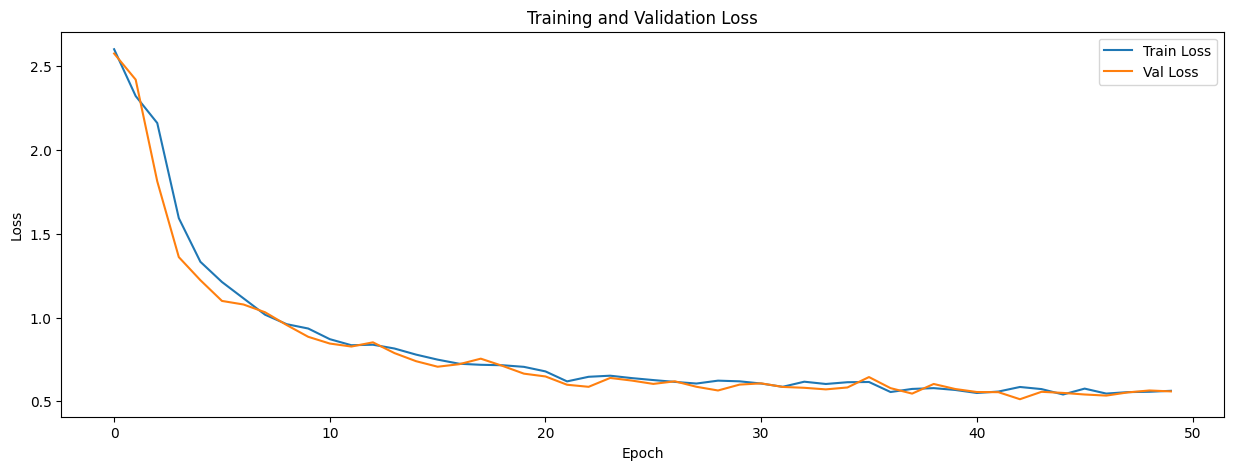

In [ ]:
plt.figure(figsize=(15, 5))

# Loss plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Evaluation

In [ ]:
model.load_state_dict(torch.load(f'best_swinir_model_{scale}_div{lambda_div}_vort{lambda_vort}_patch{patch_size}.pth'))

# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            lr = batch['lq'].to(device)
            hr = batch['gt'].to(device)

            outputs = model(lr)
            loss = criterion(outputs, hr)
            total_loss += loss.item()

    return total_loss / len(dataloader)

# Evaluate on validation set
val_loss = evaluate(model, eval_loader)
print(f'Final Test Loss: {val_loss:.4f}')

# With no div loss: Final Validation Loss: 1.2181
# With div loss and coeff = 1: Final Validation Loss: 410.3817
# Now with coeff = 0.1: 44.1709
# Now with coeff = 0.01: 7.2212
# Use L1 criterion: 2.3576, MSE Loss: 22.6876
# Using div loss = 0, Final Validation Loss: 1.1393
# With div coeff = 0.01 and vort coeff = 0.01: 11.4714
# With div coeff = 0.00001 and vort loss coeff = 0.00001: 1.2598
# With scale = 2, div and loss coeff = 0.00001 : 0.8166
# With scale = 2, coeffs = 0: ___
# With all dataset, scale = 4, coeff = 0.00001 : 0.5137
# With train on 1000 dataset; eval on 100 test: 0.5247

Final Test Loss: 0.5471


## Use PSNR

In [ ]:
model.load_state_dict(torch.load(f'best_swinir_model_{scale}_div{lambda_div}_vort{lambda_vort}_patch{patch_size}.pth'))

val_psnr = evaluate_psnr(model, eval_loader, device)
print(f'Average Test PSNR: {val_psnr:.4f}')

# With div loss and coeff = 0.01, 21.7755
# With no div loss: 27.3784 (so better with no div loss)
# With div loss coeff = 0.01 and vort loss coeff = 0.01: 22.2877
# With div coeff = 0.00001 and vort loss coeff = 0.00001: 26.4322
# With scale = 2, div and loss coeff = 0.00001 : 30.1367
# With scale = 2, coeffs = 0: ___
# With all dataset, scale = 4, coeff = 0.00001 : 35.8653
# With train on 1000 dataset; eval on 100 test: 36.2829

Average Test PSNR: 36.5077


## Use SSIM

In [ ]:
model.load_state_dict(torch.load(f'best_swinir_model_{scale}_div{lambda_div}_vort{lambda_vort}_patch{patch_size}.pth'))

# Evaluate on validation set
# Ensure model is on the correct device before evaluation
model.to(device)
val_ssim = evaluate_ssim(model, eval_loader, device)
print(f'Average Test SSIM: {val_ssim:.4f}')

# Previous output: Average Validation SSIM: 0.7489 (no divergence loss used)
# Now: Average Validation SSIM: 0.1618 (divergence loss used, with divergence coeff=1)
# Now with div loss and coeff=0.1: 0.1747
# Now with coeff=0.01: 0.2772
# Using div loss coeff = 0: 0.6623
# With div loss coeff = 0.01 and vort loss coeff = 0.01: 0.2131
# With div coeff = 0.00001 and vort loss coeff = 0.00001: 0.5488
# With scale = 2, div and loss coeff = 0.00001 : 0.8226
# With scale = 2, coeffs = 0: 0.7665
# With all dataset, scale = 4, coeff = 0.00001 : 0.9165
# With train on 1000 dataset; eval on 100 test: 0.9189

Average Test SSIM: 0.9214


## Visualize

In [ ]:
def visualize_results(model, dataloader, num_samples=3):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:
                break

            lr = batch['lq'].to(device)
            hr = batch['gt'].to(device)

            # Get model prediction
            sr = model(lr)

            # Convert to numpy
            lr_np = tensor2img(lr)
            hr_np = tensor2img(hr)
            sr_np = tensor2img(sr)

            # Plot
            fig, axes = plt.subplots(3, 3, figsize=(15, 15))

            for j in range(3):
              axes[j][0].imshow(lr_np[..., j], cmap='coolwarm')  # Show u component
              axes[j][0].set_title('Low Resolution')
              axes[j][1].imshow(sr_np[..., j], cmap='coolwarm')
              axes[j][1].set_title('Super Resolved')
              axes[j][2].imshow(hr_np[..., j], cmap='coolwarm')
              axes[j][2].set_title('High Resolution')
            plt.show()

### On validation dataset

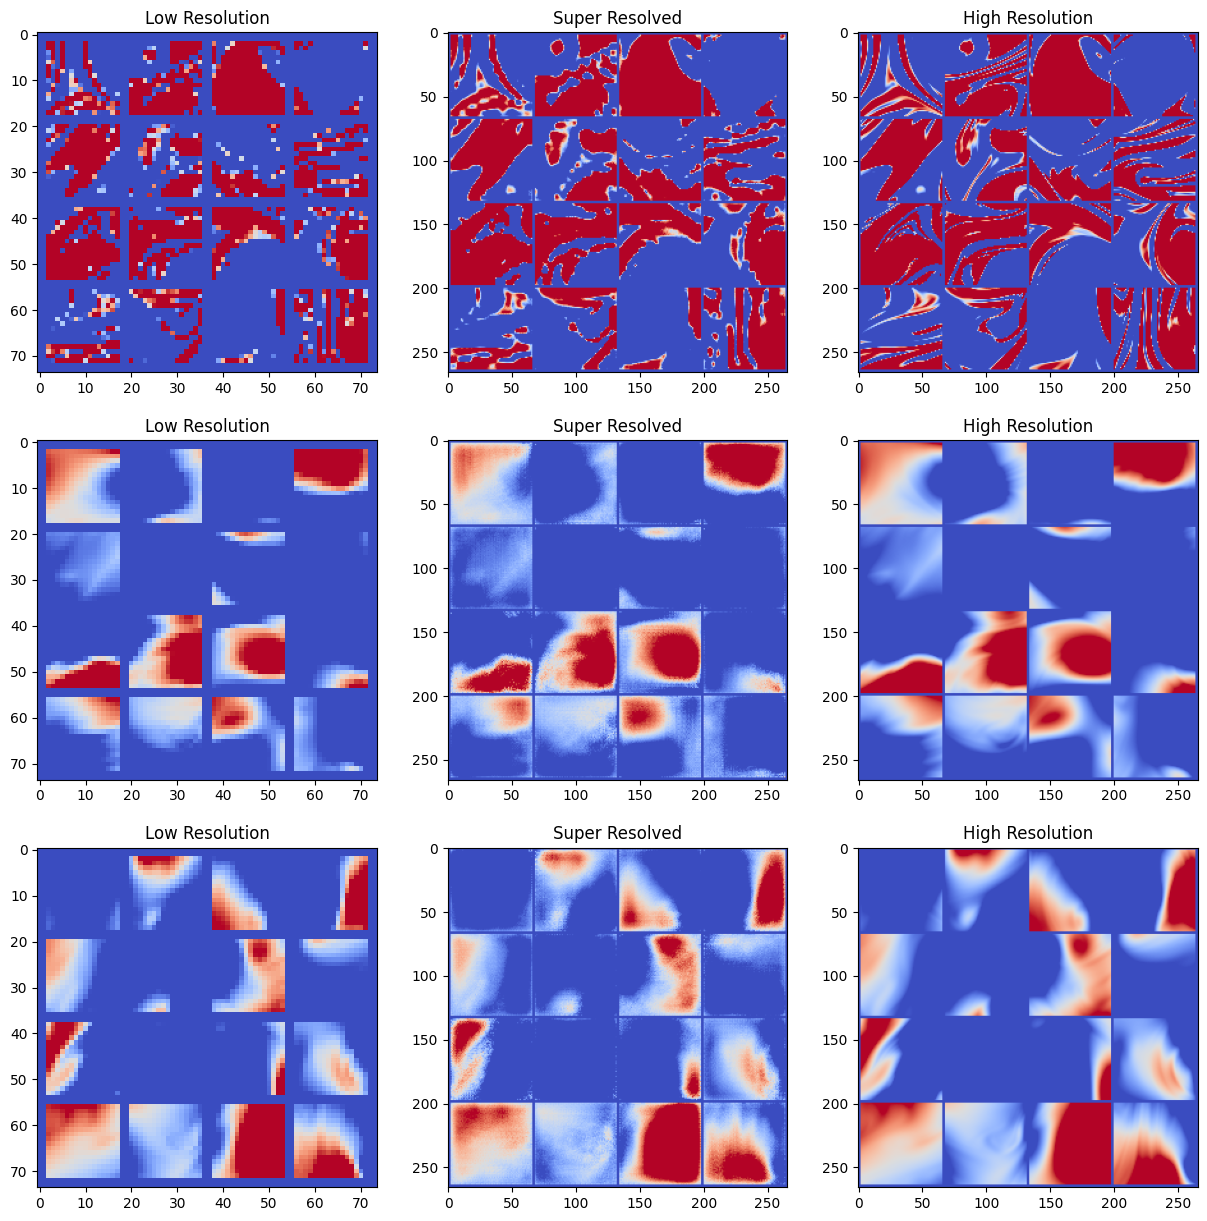

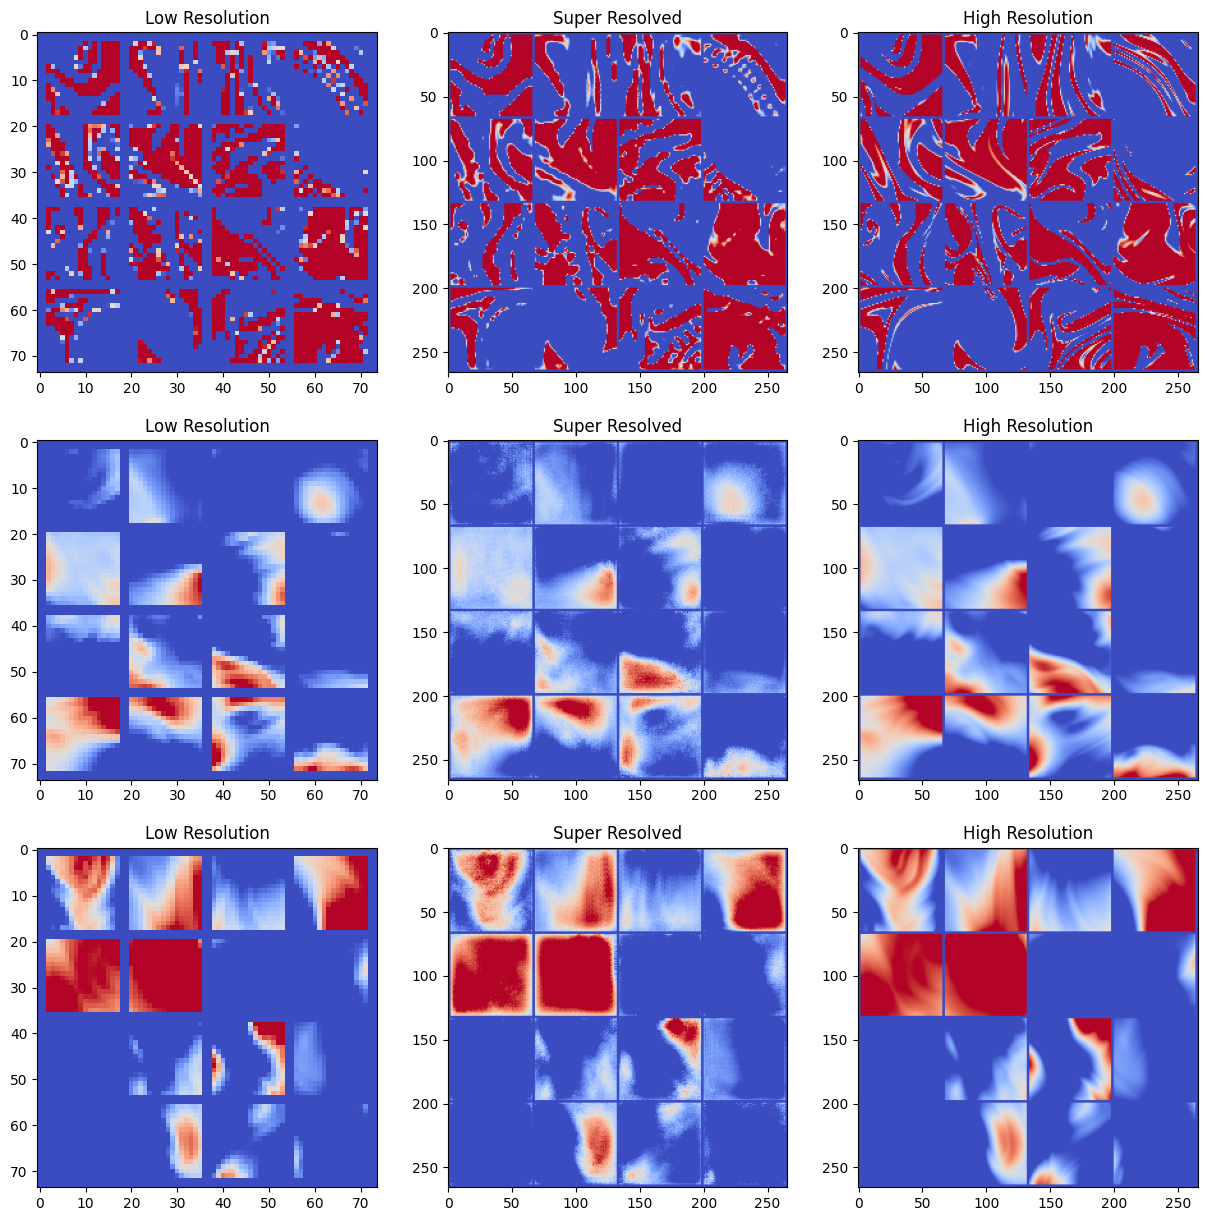

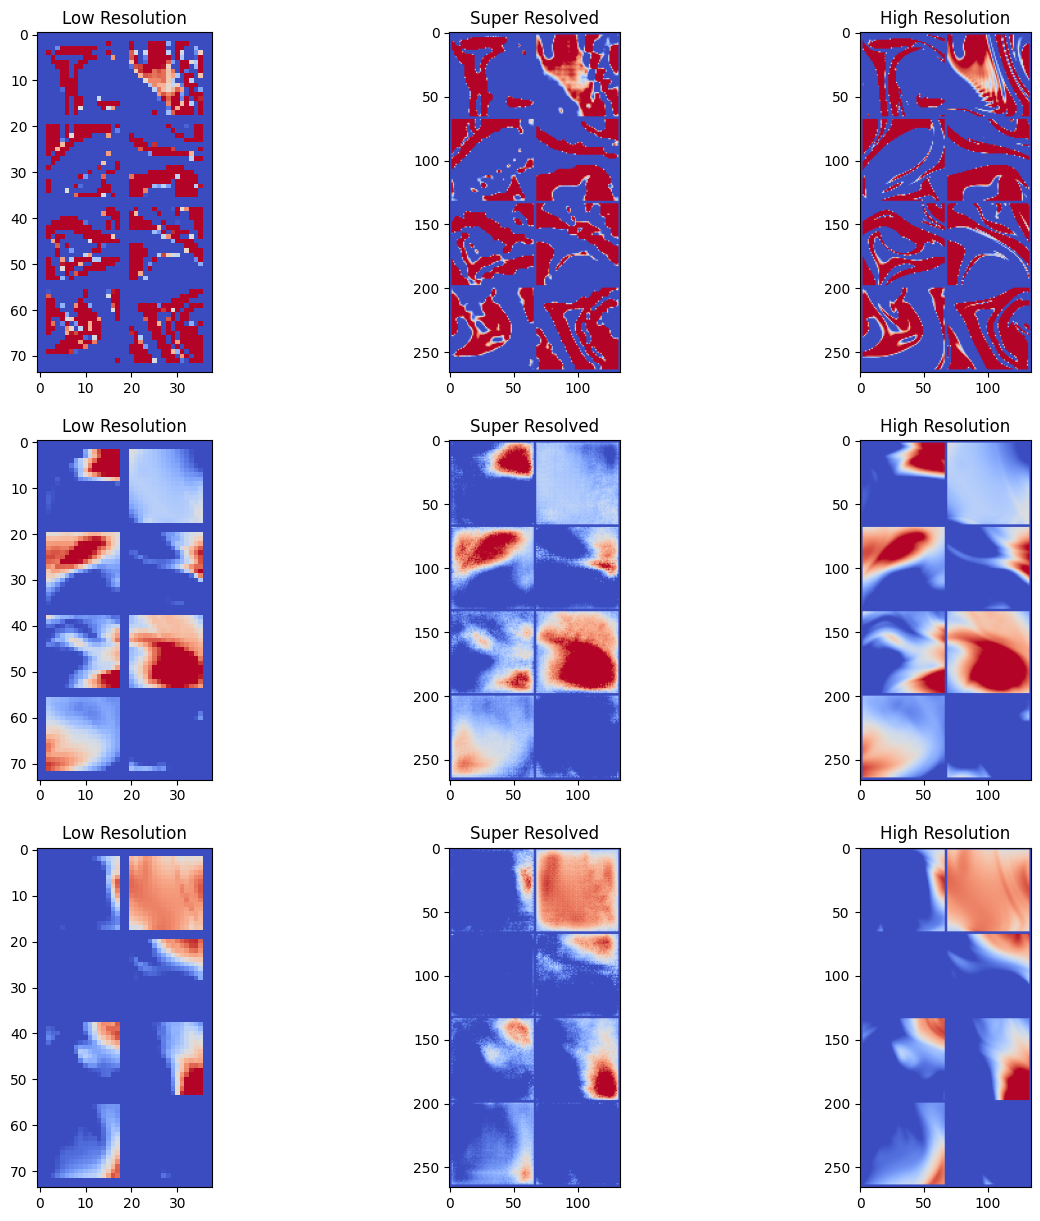

In [ ]:
# Ran with: all dataset; scale = 4; div,vort = 0.00001

model.load_state_dict(torch.load(f'best_swinir_model_4_div1e-05_vort1e-05_patch64.pth'))

# Visualize some results
visualize_results(model, val_loader)

# Save the model for later use
torch.save(model.state_dict(), f'swinir_fluid_flow_4_div0.00001_vort0.00001.pth')

### On evaluation dataset

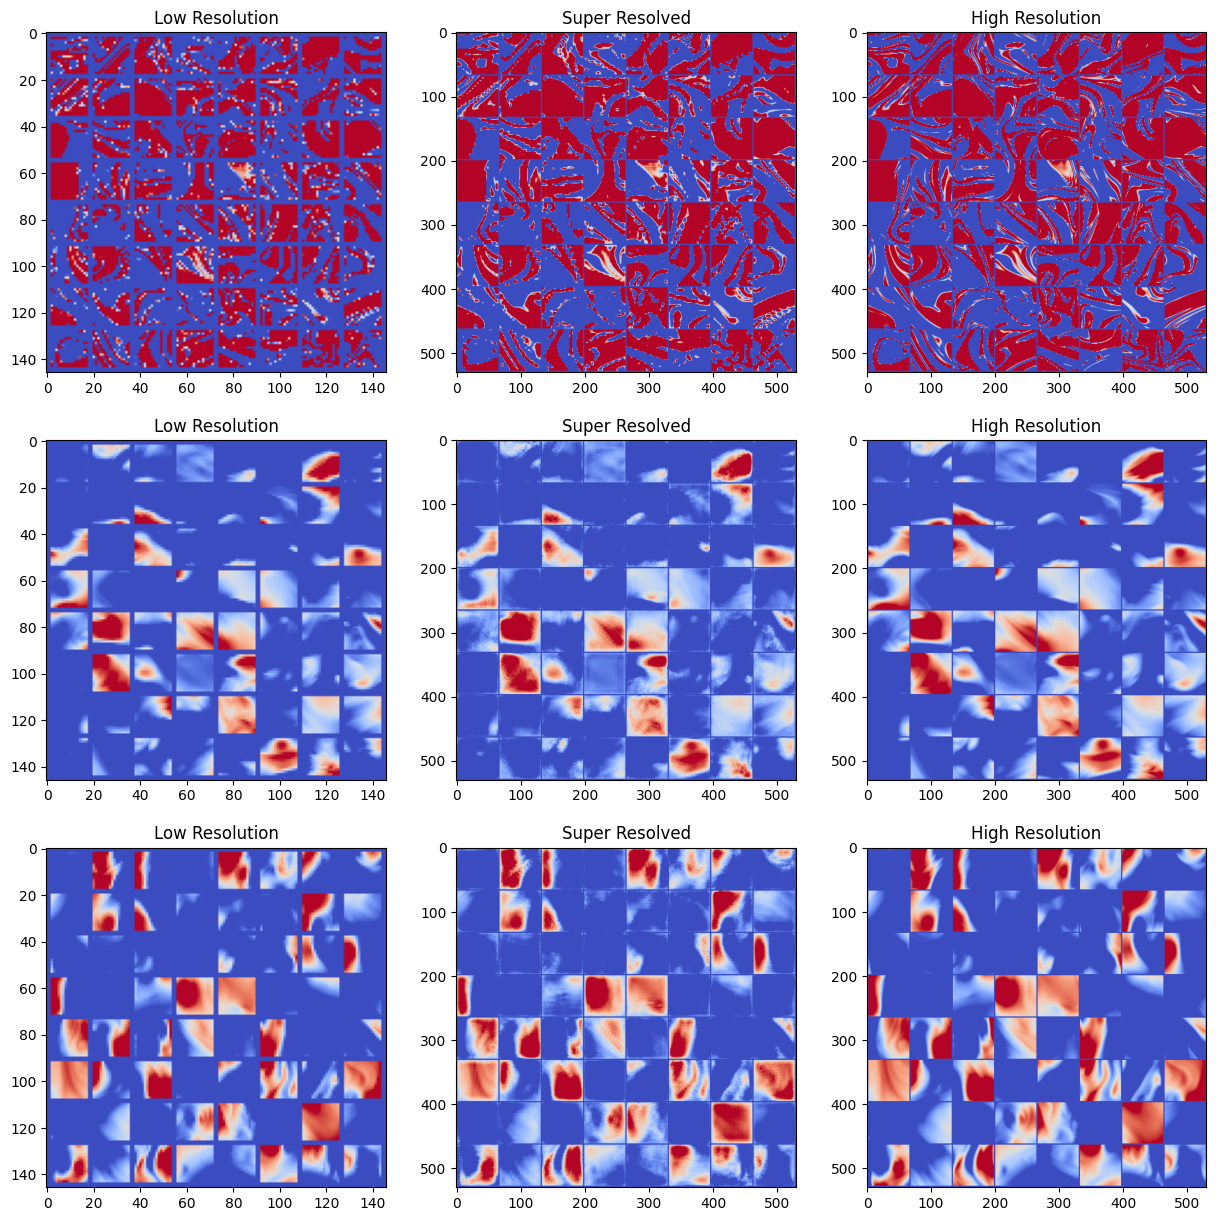

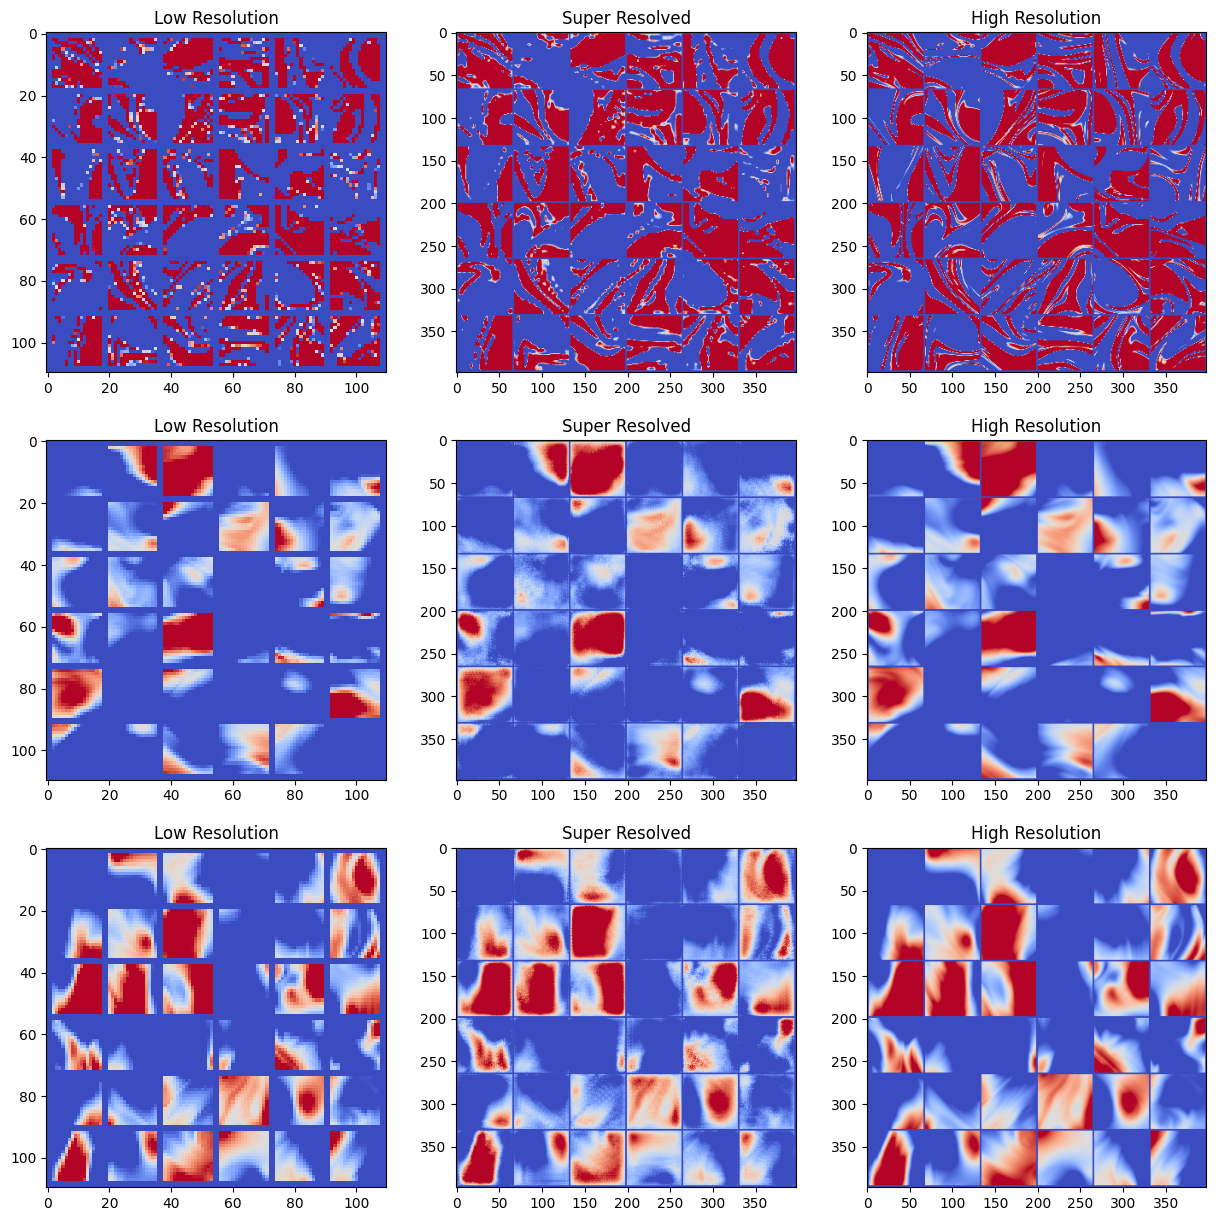

In [ ]:
# Ran with: all dataset; scale = 4; div,vort = 0.00001

model.load_state_dict(torch.load(f'best_swinir_model_4_div1e-05_vort1e-05_patch64.pth'))

# Visualize some results
visualize_results(model, eval_loader)

### Previous

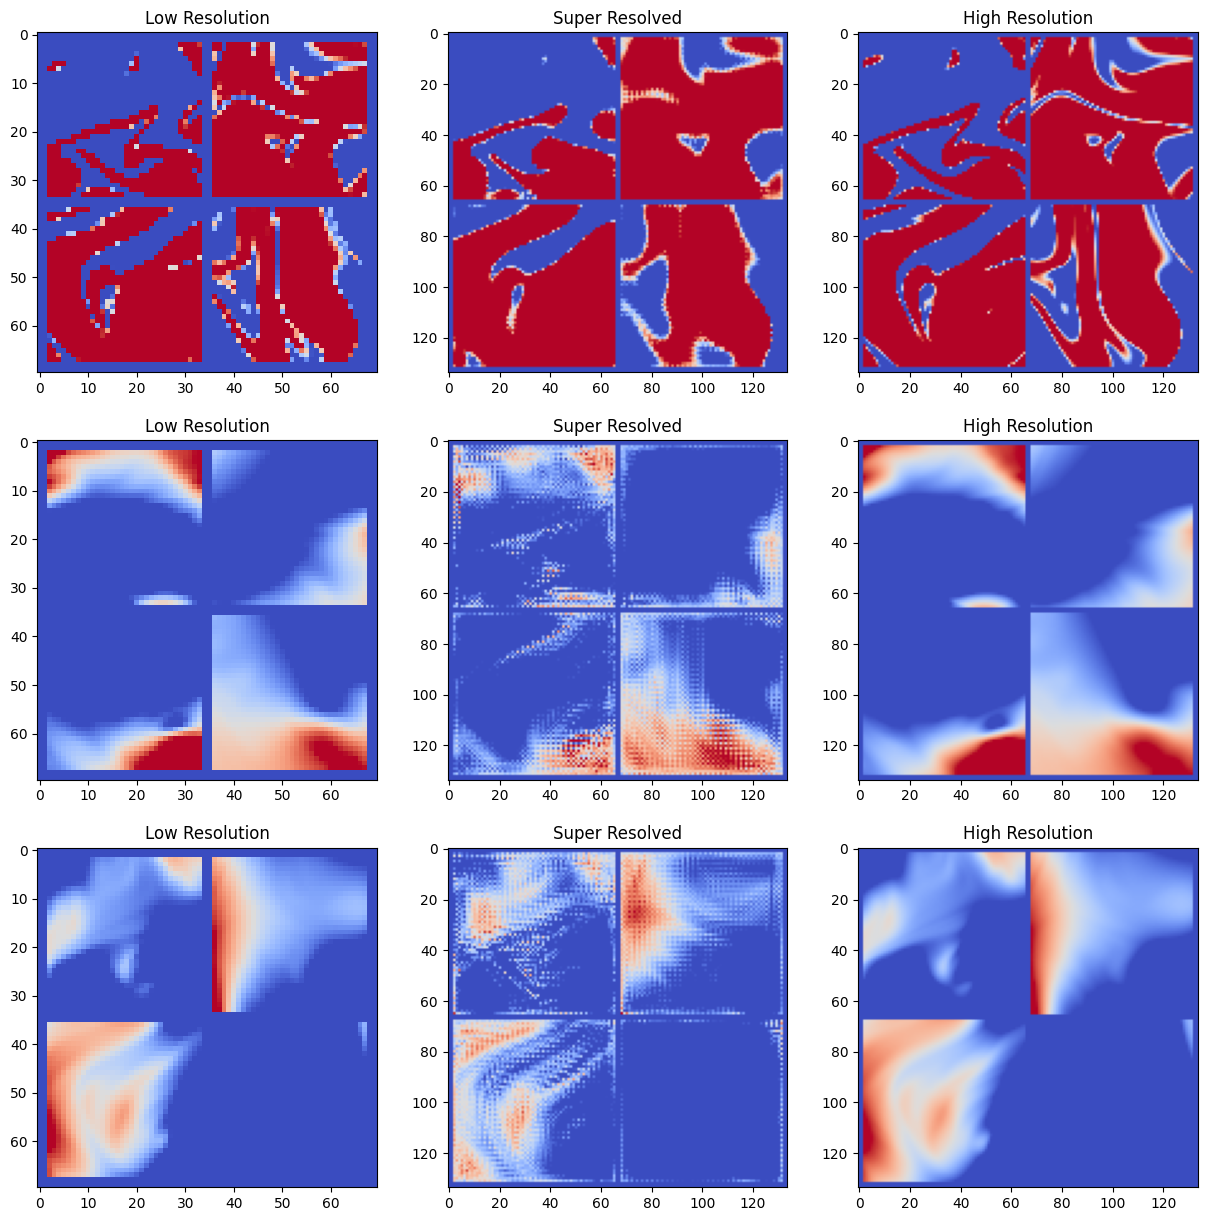

In [ ]:
# Ran with scale = 2; div,vort = 0.00001

model.load_state_dict(torch.load(f'best_swinir_model_2_div0.00001_vort0.00001.pth'))

# Visualize some results
visualize_results(model, val_loader)

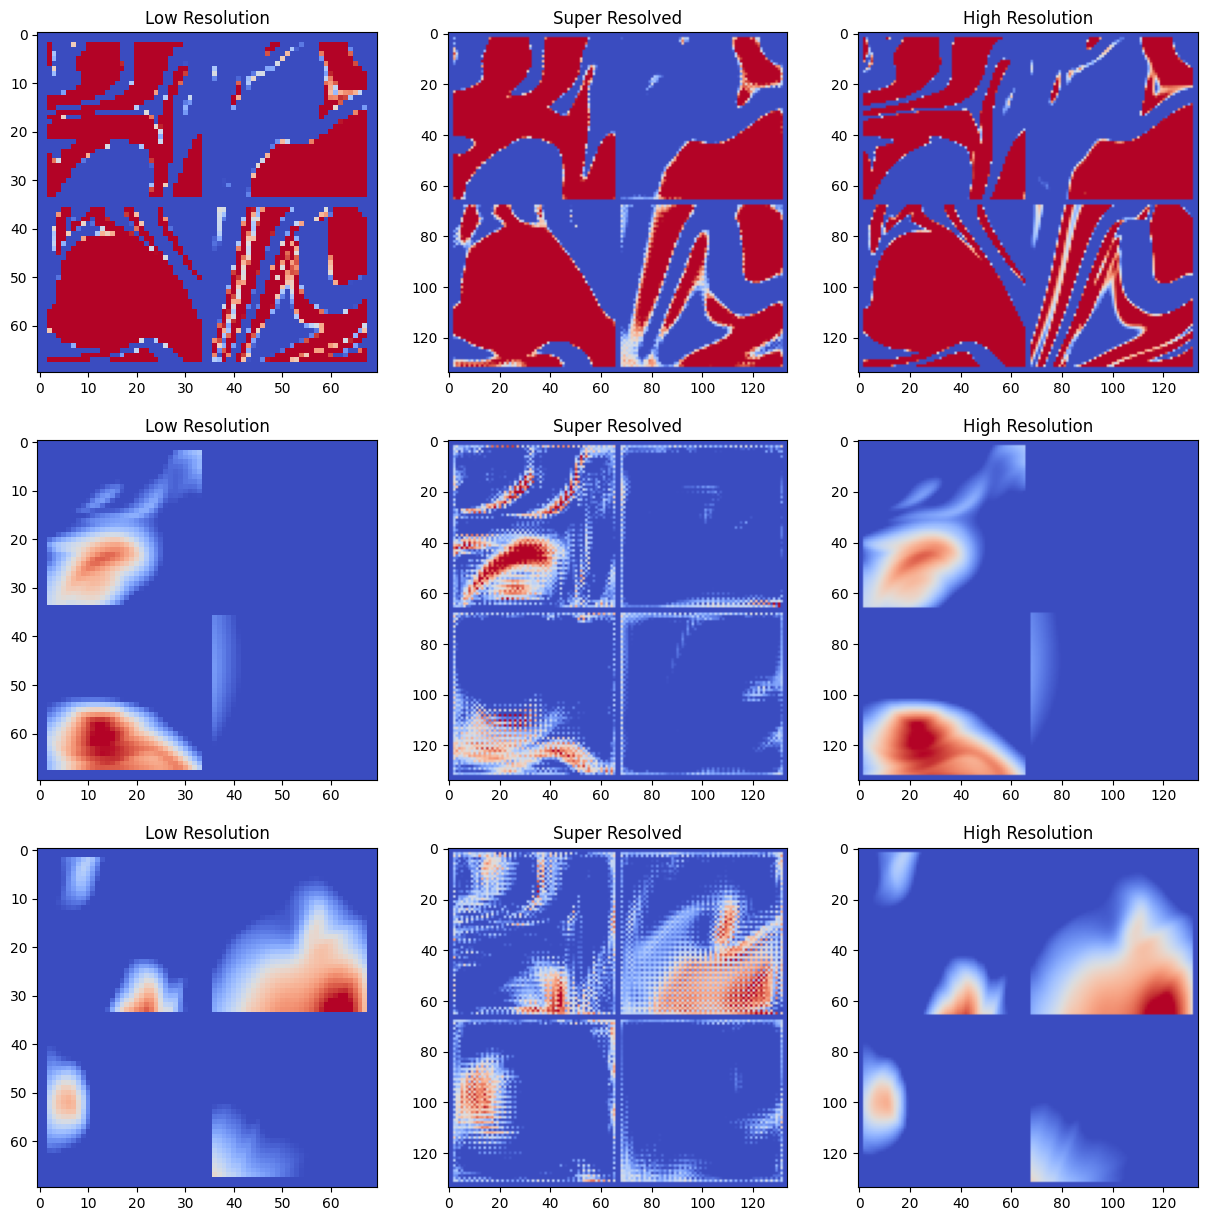

In [ ]:
# Ran with scale = 2; div,vort coeff = 0

model.load_state_dict(torch.load(f'best_swinir_model_2_div0_vort0.pth'))


# Visualize some results
visualize_results(model, val_loader)

# Save the model for later use
torch.save(model.state_dict(), f'swinir_fluid_flow_{scale}.pth')



---

